# Factors influencing overall unemployment before and during the pandemic

This part of the project looks at analysing the overall US unemployment rate to establish the factors which influence unemployment on a generic basis. The aim here is to establish an overall picture of what unemployment levels have been like over the past 10 years (both before and after the pandemic) to identify the potential factors that impact the patterns seen. Here we are interested in understanding overall US unemployment dynamics before doing a deep dive into US unemployment on a state and industry level. To do this, we review relationships between unemployment and economic factors such as: business confidence index, consumer confidence index (closely related to consumer sentiment index), consumer price index, inflation, interest rates, the number of job openings, US population, dollar strength, tax levels, wages and hours worked.

### Data preparation

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
import statsmodels.formula.api as sfm
%matplotlib inline

bci = pd.read_csv('clean_bci.csv')
cci = pd.read_csv('clean_cci.csv')
cpi = pd.read_csv('clean_cpi.csv')
csi = pd.read_csv('clean_csi.csv')
inflation = pd.read_csv('clean_inflation.csv')
# percent
ir = pd.read_csv('clean_interest_rates.csv')
# percent
job_openings = pd.read_csv('clean_job_openings.csv')
# percent
pop = pd.read_csv('clean_population.csv')
# million
unemployed_per_opening = pd.read_csv('clean_unemployed_per_opening.csv')
unemployment = pd.read_csv('clean_unemployment.csv')
dollar = pd.read_csv('clean_dollar.csv')
# percent
other = pd.read_csv('clean_other.csv')
# tax in percent

Note that Consumer Confidence surveys place a greater emphasis on employment and labor market conditions while the Consumer Sentiment survey emphasizes individual household finances. Hence, this analysis will focus on the Consumer Confidence Index.

In [3]:
datasets = [bci, cci, cpi, inflation, ir, job_openings, pop, unemployed_per_opening, unemployment, dollar]
df = reduce(lambda  left, right: pd.merge(left, right, on=['month'], how='outer'), 
            datasets).sort_values('month').reset_index(drop=True).rename(
    columns={'month': 'date', 'consumer_sentiment': 'csi', 'Total': 'unemployment'})
df.job_openings = df.job_openings.str.rstrip('%').astype(float)
df.population = df.population.str.rstrip('million').astype(float)
df = df[(df.date >= '2010-01') & (df.date < '2021-09')].reset_index(drop=True)
df = df.merge(other.rename(columns={'month':'date'}), on='date', how='outer')
df = df[['date', 'bci', 'cci', 'cpi', 'inflation', 'interest_rate', 'job_openings', 'population', 
         'dollar_strength', 'unemployed_per_job_opening', 'unemployment', 'corporate_tax', 'income_tax', 
         'wages', 'hours']]
print('Shape:', df.shape)
# Interpolate
yearly_variables = ['income_tax', 'corporate_tax', 'wages', 'hours']
for var in yearly_variables:
    df[var] = df[var].interpolate()
df.head(5)

Shape: (140, 15)


,date,bci,cci,cpi,inflation,interest_rate,job_openings,population,dollar_strength,unemployed_per_job_opening,unemployment,corporate_tax,income_tax,wages,hours
0,2010-01,NaN,NaN,217.488,2.8,0.11,2.1,308.17,92.440300,5.3,9.8,35.0,35.0,52562.000000,1772.0
1,2010-02,101.2057,98.22324,217.281,2.7,0.13,2.0,308.38,93.886680,5.7,9.8,35.0,35.0,52679.166667,1772.5
2,2010-03,101.4201,98.21968,217.353,2.7,0.16,2.0,308.57,93.149878,5.7,9.9,35.0,35.0,52796.333333,1773.0
3,2010-04,101.3545,98.19614,217.403,2.9,0.20,2.4,308.76,92.639086,4.9,9.9,35.0,35.0,52913.500000,1773.5
4,2010-05,101.0459,98.19468,217.290,3.2,0.20,2.2,308.94,95.530640,5.0,9.6,35.0,35.0,53030.666667,1774.0


In [4]:
df.shape

(140, 15)

The data used here involved obtaining monthly economic data and aggregating the datasets on the date column. Data was only considered from Jan-2010 till Aug-2021. Data was not considered prior to Jan-2010 as the financial crisis had a major impact on a lot of the economic factors considered in the data. We did not want the financial crisis to influence our analysis as the project focuses solely on the variation in unemployment as a consequence of the pandemic. 

When comparing unemployment pre- and post-pandemic, the data set was split into two. Pre-pandemic was defined to be prior to Jan-2020 and post-pandemic was defined to be Jan-2020 onwards. This is to reflect the fact that the first Covid case in the US was identified on the 20th of January, 2020.

One of the limitations of the data considered here was the fact that for some data sets, only quarterly data was available and we ideally wanted to look at monthly trends. This was the case when looking for data sets to understand income tax, corporate tax, average wages and average number of hours worked. To overcome this limitation, linear interpolation was used to fill in missing data so that it could be aggregated consistently across months with the other data sets. Linear interpolation was identified as the best method to use when filling in missing data as economic data tends to follow linear trends. 

The data processing steps used in this part of the project involved obtaining time-series (monthly) data of at least 10 years in length and aggregating all of the data sets on the date column. In order to ensure this was achievable, we had to reshape each data set so that we had one column containing parsed dates over 10 years in monthly frequency and a second column containing the value of the economic factor in question. We ensured the units of the economic factors were consistent by considering either indices (base 100) or rates (percentages). It should be noted that no outliers were identified and as mentioned, missing data was filled using linear interpolation. This process left us with a data set containing 15 columns and 140 rows.

### EDA

To understand the extreme nature of the pandemic and how it has impacted the labur market, note the follwing facts derived from this data set:

- Consumer confidence levels were lowest in 2021-08 
- The number of job openings was greatest in 2021-07
- The unemployment rate was greatest in 2020-04

<AxesSubplot:title={'center':'Unemployment rate'}, ylabel='Frequency'>

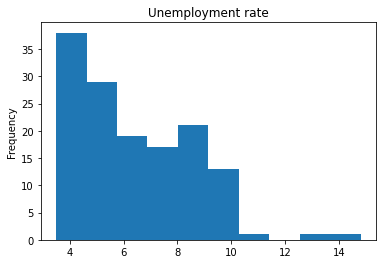

In [5]:
df.unemployment.plot.hist(title='Unemployment rate')

<AxesSubplot:title={'center':'Number of unemployed per job opening'}, ylabel='Frequency'>

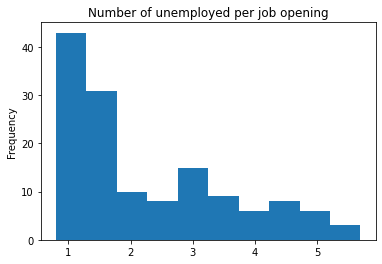

In [6]:
df.unemployed_per_job_opening.plot.hist(title='Number of unemployed per job opening')

Comparing the correlation between the unemployment rate and various factors before and after Covid was identified:

In [7]:
all_corr = df[df.date<'2020-01'].corr().unemployment.to_frame().reset_index(
    ).sort_values('unemployment').rename(columns={'unemployment': 'all_unemployment_corr'})
covid_corr = df[df.date>='2020-01'].corr().unemployment.to_frame().reset_index(
    ).rename(columns={'unemployment': 'covid_unemployment_corr'})
correlation = all_corr.merge(covid_corr)
correlation.dropna().iloc[:-1]

,index,all_unemployment_corr,covid_unemployment_corr
0,population,-0.990001,0.044398
1,job_openings,-0.973941,-0.458982
2,cpi,-0.956357,-0.490600
4,cci,-0.948485,-0.629513
5,dollar_strength,-0.913006,0.684230
6,interest_rate,-0.711384,-0.488716
8,bci,0.056981,-0.458894
10,inflation,0.585612,-0.217936
12,unemployed_per_job_opening,0.980831,0.968455


Converting this to a heatmap:

Text(0.5, 1.0, 'Correlation changes between unemployment rate and economic factors pre- and post-pandemic')

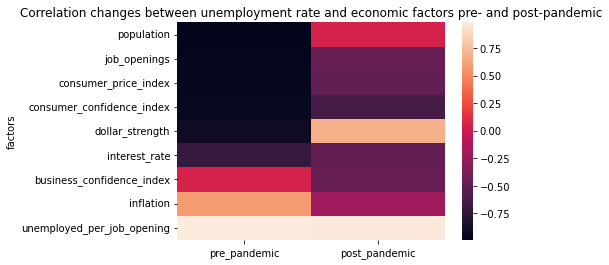

In [8]:
correlation['index'] = correlation['index'].replace({'cpi': 'consumer_price_index', 'bci': 
                                    'business_confidence_index', 'cci': 'consumer_confidence_index'})
correlation = correlation.rename(columns={'index': 'factors', 'all_unemployment_corr': 'pre_pandemic', 
                                    'covid_unemployment_corr': 'post_pandemic'})
correlation = correlation.set_index('factors').dropna().iloc[:-1]
ax = sns.heatmap(correlation)
ax.set_title('Correlation changes between unemployment rate and economic factors pre- and post-pandemic')

The correlation between the unemployment rate and various economic factors has changed during the course of the pandemic compared to any other time in the past 10 year. For example, 

- The relationship between unemployment and inflation has reversed during the pandemic.
- The relationship between unemployment and the strength of the dollar has also reversed during the pandemic.
- The unemployment rate has largely been correlated with population levels in the past but this appears to no longer be the case.
- Historically, both consumer confidence index and consumer price index were strongly correlated with unemployment but appears to be less so during the pandemic. 
- Historically, the business confidence index was weakly correlated with unemployment but appears to be much more correlated during the pandemic. 

The differences in correlation here indicate that the dynamics of the unemployment rate have changed considerably during the course of the pandemic. Whether or not these chages are significant will be examined in later parts of the project when unemployment rate is analysed on a state and industry level. Identifying if the starke correlation changes seen here are consistent on a state and/or industry level will help us to understand if unemployment rate is indeed influenced by the economic factors considered here.

Comparing the time-series of unemployment rate vs. a series of indices before and after Covid was identified:

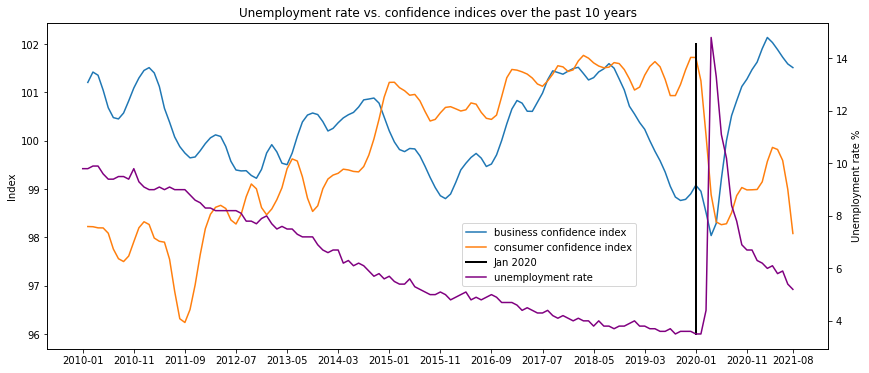

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df.date, df.bci, label='business confidence index')
ax1.plot(df.date, df.cci, label='consumer confidence index')
ax1.plot(['2020-01']*2, [96,102], label='Jan 2020', linewidth=2, color='black')
ax1.set_ylabel('Index')
ax2 = ax1.twinx()
ax2.plot(df.date, df.unemployment, label='unemployment rate', color='purple')
ax2.set_ylabel('Unemployment rate %')
plt.title('Unemployment rate vs. confidence indices over the past 10 years')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(0.76, 0.4))
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,139], rotation=45)
plt.show()

This graph shows us that both the unemplyment rate and consumer confidence index reversed direction and jumped significantly at the same time, just as Covid was identified in the US. However, the business confidence index was already pretty low before the pandemic began. From more recent data, we can see that business confidence index appears to have recovered but the consumer confidence index is still falling. We aslo see that unemployment and the confidence indices have undergone significant changes post-pandemic compared to pre-pandemic. This represents the extreme volatility the pandemic has brought into the economy and labour market. 

Comparing the time-series of unemployment rate vs. other factors before and after Covide was identified:

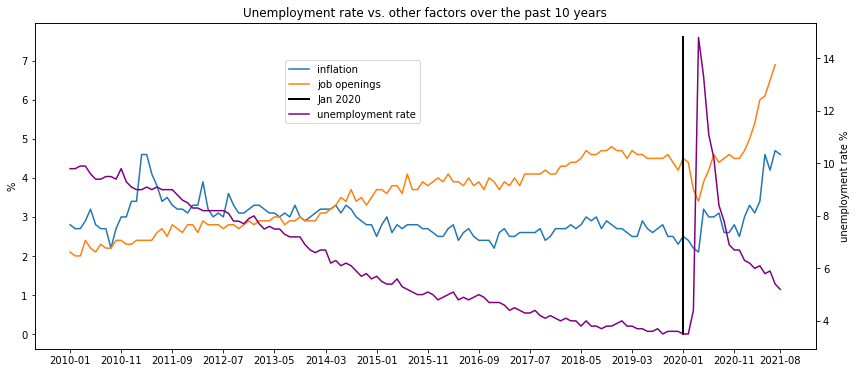

In [10]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df.date, df.inflation, label='inflation')
ax1.plot(df.date, df.job_openings, label='job openings')
ax1.plot(['2020-01']*2, [0,7.6], label='Jan 2020', color='black', linewidth=2)
ax2 = ax1.twinx()
ax2.plot(df.date, df.unemployment, label='unemployment rate', color='purple')
ax1.set_ylabel('%')
ax2.set_ylabel('unemployment rate %')
plt.title('Unemployment rate vs. other factors over the past 10 years')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, bbox_to_anchor=(0.5, 0.9))
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,139], rotation=45)
plt.show()

The upside in the number of job openings during the pandemic recovery is far greater than the downside at the start of the pandemic. Again, we see that unemployment and the other factors considered here have undergone significant changes post-pandemic compared to pre-pandemic. This further highlights the extreme volatility the pandemic has brought into the economy and labour market. 

Inflation has been fairly constant over the past 10 years and we appear to be entering a period of stagflation (high unemployment and high inflation), if unemployment remains high. This is a situation which leads to poor economic growth and was last seen in the 1970s (1). The way in which we analyse the economy and labour market may therefore be different to the way in which we have studied the relationship between unemployment and economic factors in the past 10 years. Stagflation may therefore be one potential reason why the correlations between unemployment and certain economic factors have changed significantly pre- and post-pandemic. As an extention to this project, future work could involve looking at the unemployment rate during the recession of the 1970s and comparing the results with unemployment dynamics we are witnessing today. We may be able to model post-pandemic unemployment using the patterns witnessed in the 1970s as opposed to using the relationship derived solely from the past 10 years.

(1): https://www.investopedia.com/articles/economics/08/1970-stagflation.asp

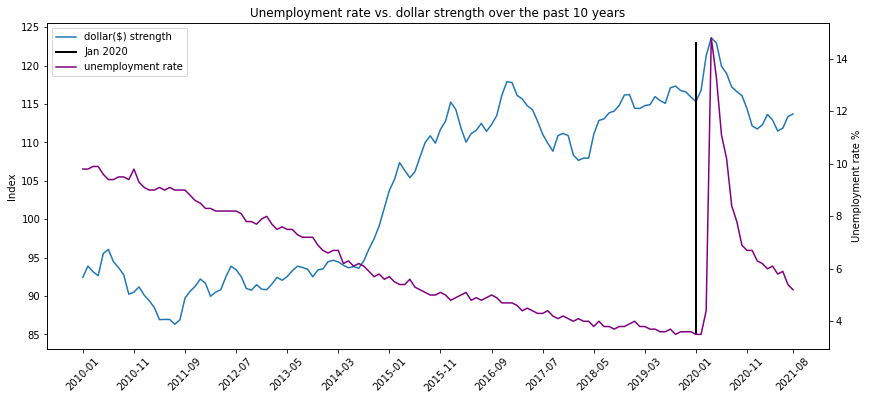

In [11]:
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.xticks(rotation=45)
ax1.plot(df.date, df.dollar_strength, label='dollar($) strength')
ax1.plot(['2020-01']*2, [85,123], label='Jan 2020', linewidth=2, color='black')
ax1.set_ylabel('Index')
ax2 = ax1.twinx()
ax2.plot(df.date, df.unemployment, label='unemployment rate', color='purple')
ax2.set_ylabel('Unemployment rate %')
plt.title('Unemployment rate vs. dollar strength over the past 10 years')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,139], rotation=45)
plt.show()

The dollar strength appears to be an extremely volatile factor pre- and post-pandemic with the biggest change witnessed in late 2014. However, we have witnessed a large decline in dollar strength post-pandemic, reaching a high that coincides with the maximum of the unemployment rate in April 2020.

### Modelling

Performing t-tests between unemployment rate and all other factors:

In [12]:
for var in ['bci', 'cci', 'cpi', 'inflation', 'interest_rate', 'job_openings', 'dollar_strength',
           'population', 'unemployed_per_job_opening', 'corporate_tax','income_tax', 'wages', 'hours']:
    T, p = ttest_ind(df.unemployment, df[var], nan_policy='omit')
    print(str(var) + ': p-values is ' + str(p))

bci: p-values is 0.0
cci: p-values is 0.0
cpi: p-values is 2.6942798171958586e-302
inflation: p-values is 2.177016384141841e-47
interest_rate: p-values is 1.484273677941901e-86
job_openings: p-values is 2.834580666156856e-31
dollar_strength: p-values is 1.458144907923261e-224
population: p-values is 0.0
unemployed_per_job_opening: p-values is 4.9418413545847714e-51
corporate_tax: p-values is 3.055252509259237e-119
income_tax: p-values is 1.9179661022930127e-257
wages: p-values is 8.047059387737592e-255
hours: p-values is 0.0


The p-value of all t-tests bewteen unemployment rate and all other variables in this data set indicate that the null hypothesis is statistically significant. This being that the mean of each factor is different from the mean unemployment rate.

Normalizing data for future reference:

In [13]:
columns = ['bci', 'cpi', 'inflation', 'interest_rate', 'job_openings', 'population', 'dollar_strength',
           'unemployed_per_job_opening', 'unemployment', 'corporate_tax', 'income_tax', 'wages', 'hours']
norm_df = df.copy()
for col in columns:
    norm_df[col] = (norm_df[col] - norm_df[col].mean()) / norm_df[col].std()
norm_df.head(5)

,date,bci,cci,cpi,inflation,interest_rate,job_openings,population,dollar_strength,unemployed_per_job_opening,unemployment,corporate_tax,income_tax,wages,hours
0,2010-01,NaN,NaN,-1.696353,-0.299380,-0.614976,-1.638282,-1.789611,-1.085302,2.265876,1.537999,0.760915,-1.952953,-1.529771,-1.015795
1,2010-02,0.998256,98.22324,-1.711463,-0.505850,-0.587791,-1.744445,-1.758295,-0.952812,2.559610,1.537999,0.760915,-1.952953,-1.507883,-0.919250
2,2010-03,1.236732,98.21968,-1.706207,-0.505850,-0.547013,-1.744445,-1.729960,-1.020304,2.559610,1.582737,0.760915,-1.952953,-1.485996,-0.822705
3,2010-04,1.163766,98.19614,-1.702558,-0.092911,-0.492641,-1.319791,-1.701626,-1.067093,1.972141,1.582737,0.760915,-1.952953,-1.464108,-0.726159
4,2010-05,0.820512,98.19468,-1.710806,0.526497,-0.492641,-1.532118,-1.674783,-0.802223,2.045575,1.448525,0.760915,-1.952953,-1.442220,-0.629614


Identifying a statistically significant linear model for the overall unemployment rate:

In [14]:
model = 'unemployment~cci+inflation+job_openings+dollar_strength+corporate_tax+interest_rate'
lm = sfm.ols(formula = model, data = df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     161.9
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           4.45e-58
Time:                        14:05:01   Log-Likelihood:                -159.01
No. Observations:                 138   AIC:                             332.0
Df Residuals:                     131   BIC:                             352.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          90.4799      9.635     

Identifying a statistically significant linear model for the unemployment rate pre-pandemic:

In [15]:
pre_model = 'unemployment~population+hours+cci+interest_rate+hours+job_openings'
pre_lm  = sfm.ols(formula = pre_model, data = df[df.date<'2020-01']).fit()
print(pre_lm.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3992.
Date:                Sun, 17 Oct 2021   Prob (F-statistic):          2.61e-125
Time:                        14:05:01   Log-Likelihood:                 54.809
No. Observations:                 119   AIC:                            -97.62
Df Residuals:                     113   BIC:                            -80.94
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       134.8337     11.107     12.139

This linear model indicates that unemployment rate pre-pandemic was influenced by population levels, the average number of hours worked, the consumer confidence index, the interest rate and the number of job openings. In particular, the unemployment rate is high when the population levels are decreasing, consumer confidence is down and interest rates are rising.

Identifying a statistically significant linear model for the unemployment rate post-pandemic:

In [16]:
post_model = 'unemployment~bci+interest_rate'
post_lm = sfm.ols(formula = post_model, data = df[df.date>='2020-01']).fit()
print(post_lm.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     43.01
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           2.23e-07
Time:                        14:05:01   Log-Likelihood:                -31.887
No. Observations:                  20   AIC:                             69.77
Df Residuals:                      17   BIC:                             72.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       197.5423     24.185      8.168

This linear model indicates that unemployment rate post-pandemic is influenced by interest rates and business confidence index. In particular, the unemployment rate is high when business confidence is down and interest rates are declining.

# Conclusions

Pre-pandemic model: unemployment_rate = 134.83 - 0.27\*population - 0.01\*hours_worked - 0.18\*consumer_confidence_index + 0.35\*interest_rate - 0.43\*job_openings
    
Post-pandemic model: unemployment_rate = 197.54 - 1.88\*business_confidence_index - 5.77\*interest_rate
    

From a comparison of the linear models above, we see that interest rate is a strong exogenous variable when modelling unemployment rate. In particular, interest rates have a positive realtionship with unemployment in the long term and a negative relationship with unemployment in the short term. Furthermore, the difference in impact that interest rate changes has on unemployment rate pre- and post-pandemic suggests that decreasing interest rates in the past may have worked but this may no longer be the case. This supports the idea of stagflation where interest rates are typically set high in order to control inflation levels. However, this conclusion would require further investigation using economic and labour market data from the 1970s.

A notable difference from the linear models is that pre-pandemic unemployment levels decreased with increasing consumer confidence however, post-pandemic unemployment levels decreased with increasing business confidence. Potential explanations for this result could be that the Federal Pandemic Unemployment Compensation scheme and Payment Protection Programme increased confidence among employees regarding the labour market. These and other job retention schemes were implemented by the Federal Government to encourage businesses to retain their employees during the pandemic (2). These interventions could explain why consumer confidence is less influential in studying unemployment rate post-pandemic compared to pre-pandemic. In addition, the near term influence of business confidence on unemployment could reflect the increasing concerns businesses have over unemployment as we head towards the recovery stage of the pandemic. This relationship could be explained by potential unquantifiable attributes such as:
- Increases in post-pandemic demand
- Decreases in supply due to lock-down restrictions
- Problems employing people in areas requiring mandatory vaccinations
- Difficulties attracting employees who are looking to improve work-life balance by seeking remote working benefits
- Issues attracting employees who have decided to leave the work force whether they have decided to reire early or wish to pursue their own businesses they have built during lock-down.

The R^2 is 99% for the pre-pandemic model and 82% for the post-pandemic model. This indicates that we have been able to explain the variation in pre-pandemic unemployment well using the economic factors analysed here. However, this result also indicates that there may be factors influencing the variation in the post-pandemic unemployment rate that we have not been able to identify. Nevertheless, the variation in unemployment before and after the pandemic is different and suggests that the ways previously used to control unemployment may no longer work. This point further emphasises the need for further investigation to study unemployment rate during the stagflation fuelled recession of the 1970s.

(2): https://www.instituteforgovernment.org.uk/coronavirus-support-workers-comparison